Draw a dumper moving pattern compare to other types of machines 

In [23]:
import pandas as pd

Load trips on a patricular day:

In [24]:
day = "03-07-2022"
df = pd.read_csv(f"GPSData/trips/{day}.csv")
df_info = pd.read_csv(f"GPSData/tripsInfo/{day}.csv")

In [25]:
# Check the unique machine types
df_info["MachineType"].unique()

array(['Truck', 'Dumper'], dtype=object)

## Preparing

In [26]:
# We merge two files for comfortable work
df = pd.merge(df_info, df, on="TripLogId")

In [27]:
# Convert timestamp to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

Filter data to only cover the specific day chosen. We assume that noone is working at night. 

In [28]:
df = df[df['Timestamp'].dt.date == pd.to_datetime(day).date()]

In [29]:
df["Timestamp"].dt.date.unique()

array([datetime.date(2022, 3, 7)], dtype=object)

In [46]:
dumpers = df[df["MachineType"] == "Dumper"].copy()
trucks = df[df["MachineType"] == "Truck"].copy()

## Visualising dumper trips

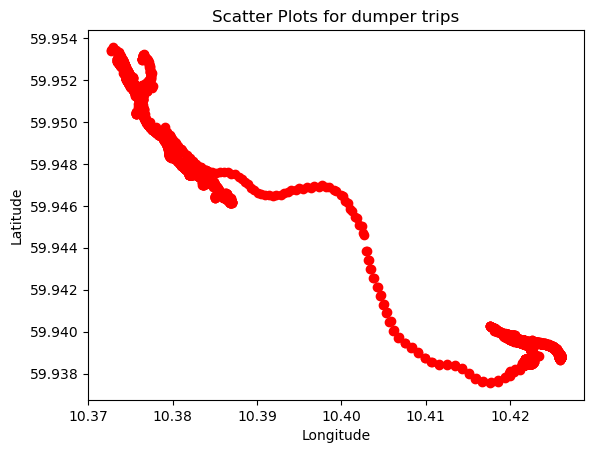

In [54]:
import matplotlib.pyplot as plt

# Group the DataFrame by TripID
grouped = dumpers.groupby('TripLogId')

# Create scatter plots for each trip
for trip_id, trip_data in grouped:
    plt.scatter(trip_data['Longitude'], trip_data['Latitude'], c="Red") #label=f'Trip {trip_id}')

# Add labels, legend, and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend()
plt.title('Scatter Plots for dumper trips')

# Show the plots
plt.show()


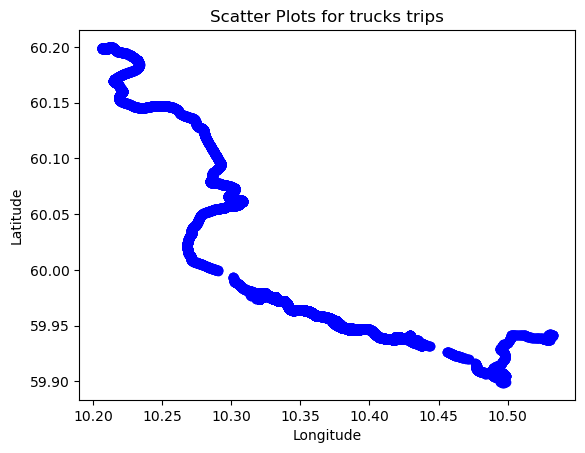

In [55]:
import matplotlib.pyplot as plt

# Group the DataFrame by TripID
grouped = trucks.groupby('TripLogId')

# Create scatter plots for each trip
for trip_id, trip_data in grouped:
    plt.scatter(trip_data['Longitude'], trip_data['Latitude'], c="Blue")

# Add labels, legend, and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend()
plt.title('Scatter Plots for trucks trips')

# Show the plots
plt.show()

We can see that trucks travel much furthure than dumpers. Let's get an idea how far they travel:

In [57]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    return distance

In [61]:
def diagonal_distance(df):
    return haversine_distance(df["Latitude"].max(), df["Longitude"].min(), df["Latitude"].min(), df["Longitude"].max())

In [62]:
diagonal_distance(trucks)

38.091448007175394

In [64]:
diagonal_distance(dumpers)

3.4690709053398154

From the graphs above we also see that dumpers and trucks intersect

## Find the region where dumpers and trucks intersect

**Construct a GeoDataFrame from a DataFrame**

In [65]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [67]:
# Create a geometry column from Latitude & Longitude

dumpers['geometry'] = dumpers.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)
trucks['geometry'] = trucks.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)

In [68]:
dumpers.geometry

2564       POINT (10.420804015582256 59.93960932240275)
2565       POINT (10.420820357142576 59.93960263655923)
2566         POINT (10.420867556840117 59.939602665522)
2567       POINT (10.420904872610688 59.93958538328874)
2568         POINT (10.42095949539368 59.9395668810006)
                              ...                      
203097     POINT (10.375727770699166 59.95126610172488)
203098    POINT (10.375584038986768 59.951258459777286)
203099     POINT (10.375679537060886 59.95126545672214)
203100      POINT (10.375686281834792 59.9512470123716)
203101      POINT (10.37558432292892 59.95135412770942)
Name: geometry, Length: 11787, dtype: object

These are decimal dergee units, so we create GeoDataFrames with this setting

In [70]:
degrees_crs = "epsg:4326"
dumpers_geo = gpd.GeoDataFrame(dumpers, crs=degrees_crs, geometry = dumpers.geometry)
trucks_geo = gpd.GeoDataFrame(trucks, crs=degrees_crs, geometry = trucks.geometry)

We convert decimal degrees to meters:

In [71]:
#set mesuraments of a geometry column into a meters
dumpers_geo.geometry = dumpers_geo.geometry.to_crs(epsg = 3857)
trucks_geo.geometry = trucks_geo.geometry.to_crs(epsg = 3857)

In [72]:
dumpers_geo.geometry.head(2)

2564    POINT (1160038.597 8386304.826)
2565    POINT (1160040.416 8386303.341)
Name: geometry, dtype: geometry

We find the region where dumpers operate by computing convex hull of the dumper points

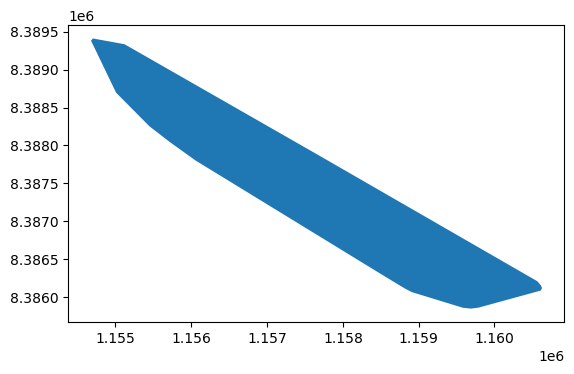

In [74]:
convex_hull = dumpers_geo.unary_union.convex_hull
convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull])
convex_hull_gdf.plot()
plt.show()

In [78]:
convex_hull_gdf_geo = gpd.GeoDataFrame(convex_hull_gdf, crs= "epsg:3857", geometry = convex_hull_gdf.geometry)

In [77]:
convex_hull_gdf_geo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [79]:
trucks_geo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Find the truck points that intersect with dumper convex hull

In [81]:
joint_gdf = gpd.sjoin(trucks_geo, convex_hull_gdf_geo, predicate="intersects")
joint_gdf.head(5)

,TripLogId,DumperMachineNumber,MachineType,LoadLongitude,LoadLatitude,DumpLongitude,DumpLatitude,MassTypeMaterial,Quantity,Timestamp,Latitude,Longitude,Uncertainty,geometry,index_right
0,6225a07a03d57f0000de776a,20,Truck,10.38603,59.946488,10.324452,59.97659,Stone,16.0,2022-03-07 06:04:41.869000+00:00,59.946488,10.386030,8.942958,POINT (1156167.522 8387833.747),0
1,6225a07a03d57f0000de776a,20,Truck,10.38603,59.946488,10.324452,59.97659,Stone,16.0,2022-03-07 06:05:00.868000+00:00,59.946486,10.386051,9.521081,POINT (1156169.873 8387833.280),0
2,6225a07a03d57f0000de776a,20,Truck,10.38603,59.946488,10.324452,59.97659,Stone,16.0,2022-03-07 06:05:37.866000+00:00,59.946474,10.386081,8.552684,POINT (1156173.275 8387830.584),0
3,6225a07a03d57f0000de776a,20,Truck,10.38603,59.946488,10.324452,59.97659,Stone,16.0,2022-03-07 06:06:36.863000+00:00,59.946478,10.386038,8.830489,POINT (1156168.431 8387831.539),0
4,6225a07a03d57f0000de776a,20,Truck,10.38603,59.946488,10.324452,59.97659,Stone,16.0,2022-03-07 06:06:38.863000+00:00,59.946482,10.386002,9.107995,POINT (1156164.435 8387832.418),0


***Scatterplot of the trucks around the loading site***

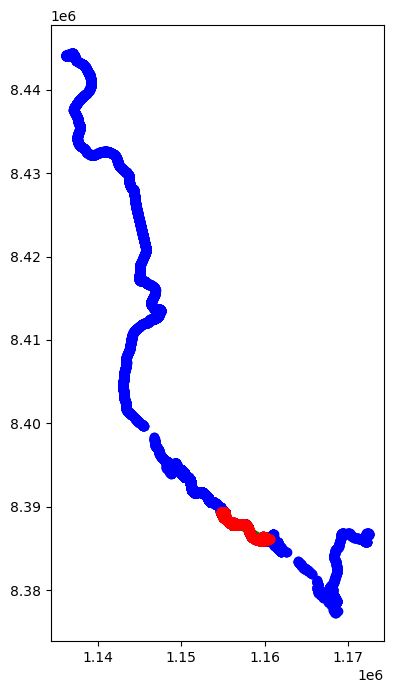

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))
trucks_geo.plot(ax=ax, color="blue")
convex_hull_gdf_geo.plot(ax=ax, color="green")
joint_gdf.plot(ax=ax, color="red")
plt.show()

In [ ]:
# Let´s figure out why trucks seem to move out of the loading site in 2 different directions. We need to understand why. I have 3 hypotheses:


#2. Trucks have a resting site in one end, but a dumping site in another. To see this, factor time into the scatterplot by using a gradient - use a light color for the morning, dark color for mid-day, and light color again for evening. If a clear pattern emerges, with one color going one way, and another going the other, then this hypothesis is correct.

#3. The loading site is bigger.

In [ ]:
#First hypothesis : Sand and stone are moved from the loading site to each their own dumping site. 
#To test this, color trucks moving sand one color, and trucks moving stone another.
#If a clear pattern emerges, with one color going one way, and another going the other, then this hypothesis is correct.trucks

<AxesSubplot:>

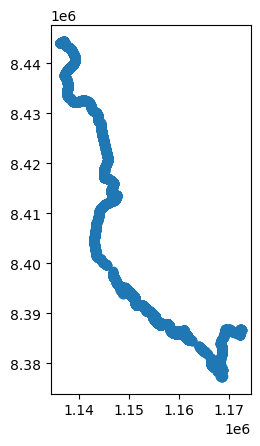

In [ ]:
trucks_geo.plot()

In [ ]:
trucks_geo["MassTypeMaterial"].unique()

array(['Stone', 'Equipment', 'Soil', '4'], dtype=object)

In [ ]:
print(trucks_geo[trucks_geo["MassTypeMaterial"] == "4"].shape)
print(trucks_geo[trucks_geo["MassTypeMaterial"] == "Equipment"].shape)
print(trucks_geo[trucks_geo["MassTypeMaterial"] == "Stone"].shape)
print(trucks_geo[trucks_geo["MassTypeMaterial"] == "Soil"].shape)

(1109, 14)
(4792, 14)
(160328, 14)
(24969, 14)


In [ ]:
trucks_equipment = trucks_geo[trucks_geo["MassTypeMaterial"] == "Equipment"]
trucks_stone = trucks_geo[trucks_geo["MassTypeMaterial"] == "Stone"]
trucks_soil = trucks_geo[trucks_geo["MassTypeMaterial"] == "Soil"]
trucks_4 = trucks_geo[trucks_geo["MassTypeMaterial"] == "4"]

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 2, 1) 
ax2 = fig.add_subplot(2, 2, 2)
trucks_soil.plot(ax=ax1, color ="green")
trucks_stone.plot(ax=ax2, color = "white", edgecolor="blue")
ax1.set_title("Soil")
ax2.set_title("Stone")
plt.show()

NameError: name 'plt' is not defined

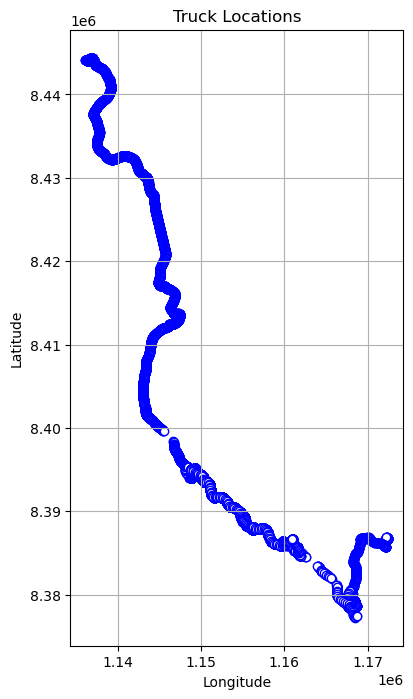

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
trucks_soil.plot(ax=ax, color ="green")
trucks_stone.plot(ax=ax, color = "white", edgecolor="blue")
plt.title('Truck Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

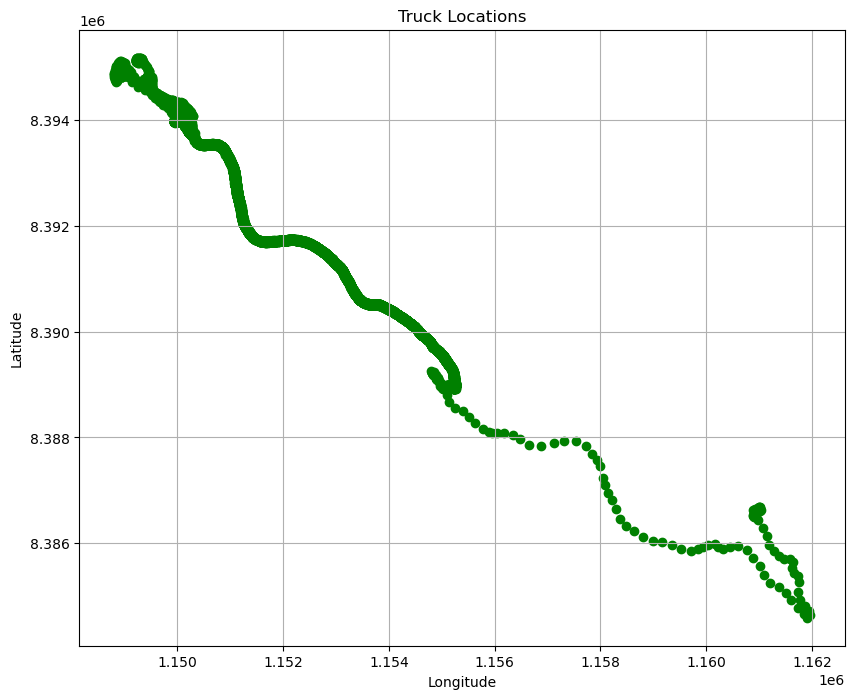

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
trucks_soil.plot(ax=ax, color ="green")
plt.title('Truck Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

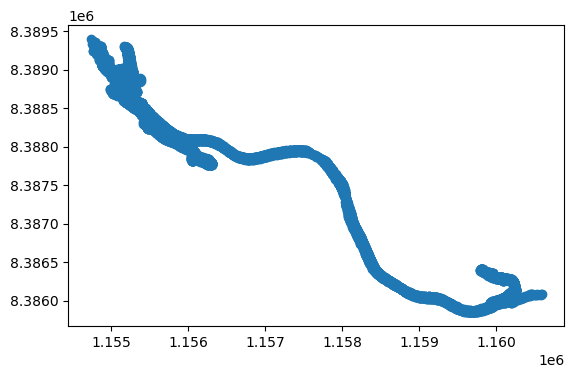

39835

In [ ]:
joint_gdf.plot()
plt.show()
joint_gdf.shape[0]

***Indentify min and max timestaps on each trip***

In [84]:
joint_gdf.columns

Index(['TripLogId', 'DumperMachineNumber', 'MachineType', 'LoadLongitude',
       'LoadLatitude', 'DumpLongitude', 'DumpLatitude', 'MassTypeMaterial',
       'Quantity', 'Timestamp', 'Latitude', 'Longitude', 'Uncertainty',
       'geometry', 'index_right'],
      dtype='object')

In [86]:
add_columns = joint_gdf[["TripLogId","MassTypeMaterial", "Quantity"]]
print(add_columns.head(2))

                  TripLogId MassTypeMaterial  Quantity
0  6225a07a03d57f0000de776a            Stone      16.0
1  6225a07a03d57f0000de776a            Stone      16.0


In [91]:
df_entry_exit = min_max.merge(add_columns, on="TripLogId")
df_entry_exit.rename(columns={'min': 'Entry', "max": "Exit"}, inplace=True)
df_entry_exit

,TripLogId,Entry,Exit,MassTypeMaterial,Quantity
0,6225a07a03d57f0000de776a,2022-03-07 06:04:41.869000+00:00,2022-03-07 06:28:44.850000+00:00,Stone,16.0
1,6225a07a03d57f0000de776a,2022-03-07 06:04:41.869000+00:00,2022-03-07 06:28:44.850000+00:00,Stone,16.0
2,6225a07a03d57f0000de776a,2022-03-07 06:04:41.869000+00:00,2022-03-07 06:28:44.850000+00:00,Stone,16.0
3,6225a07a03d57f0000de776a,2022-03-07 06:04:41.869000+00:00,2022-03-07 06:28:44.850000+00:00,Stone,16.0
4,6225a07a03d57f0000de776a,2022-03-07 06:04:41.869000+00:00,2022-03-07 06:28:44.850000+00:00,Stone,16.0
...,...,...,...,...,...
39830,622654212310460000598ebd,2022-03-07 18:51:12.920000+00:00,2022-03-07 19:08:13.955000+00:00,Soil,17.0
39831,622654212310460000598ebd,2022-03-07 18:51:12.920000+00:00,2022-03-07 19:08:13.955000+00:00,Soil,17.0
39832,622654212310460000598ebd,2022-03-07 18:51:12.920000+00:00,2022-03-07 19:08:13.955000+00:00,Soil,17.0
39833,622654212310460000598ebd,2022-03-07 18:51:12.920000+00:00,2022-03-07 19:08:13.955000+00:00,Soil,17.0
